<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [ ]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [ ]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

In [ ]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

In [ ]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

In [ ]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

In [ ]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 1000/1000 [00:18<00:00, 55.55it/s]


MSE: 0.26
RMSE: 0.51


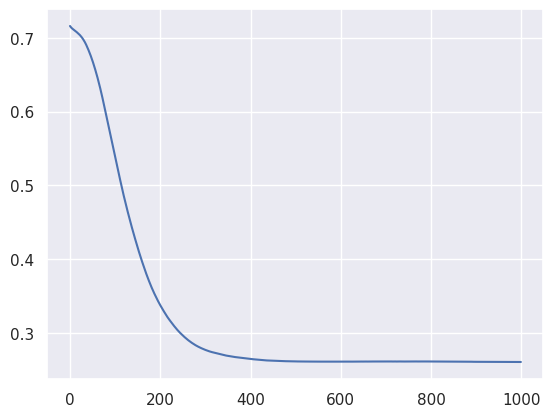

In [12]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ F1 측정

+ 비교 대상의 측정치

In [13]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [14]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.875


+ 2000~40000까지의 R-squared score 측정 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 190/190 [00:00<00:00, 523.27it/s]


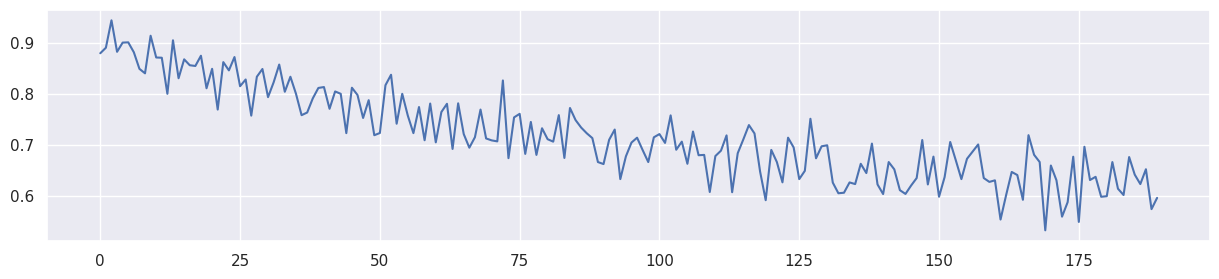

{'lambda': ['Feature 5'], 'test_f1': [0.875], 'init_f1': [0.8792270531400966], 'mean_f1': [0.7188182846325013], 'last_f1': [0.5966850828729282], 'MI(y^,z)': [0.26166691811002174]}


In [15]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)


## feature 5개 + bucket(B) = feature 6개를 학습

In [16]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

,x0,x1,x2,x3,z0,b
0,2.231833,0.663053,2.160447,1.180836,1.125117,0
1,1.326272,2.285045,2.362769,2.638806,2.171340,0
2,1.845348,3.743190,3.310210,1.772473,2.576518,0
3,2.974414,-0.229197,1.024580,1.387895,0.873782,0
4,2.854022,3.102544,1.610779,1.774781,2.490660,0
...,...,...,...,...,...,...
39995,0.085122,-0.571732,1.527233,1.867146,-1.177338,399
39996,1.069521,-0.221247,1.324087,1.798258,4.045168,399
39997,0.429295,2.593988,2.329410,1.859496,1.785665,399
39998,1.611266,-0.588687,-0.591898,2.126287,9.291351,399


100%|██████████| 1000/1000 [00:18<00:00, 54.44it/s]


MSE: 0.27
RMSE: 0.52


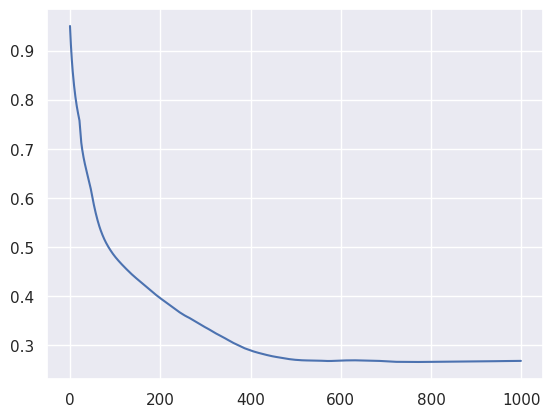

In [17]:
seed_everything()

X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(6, 24),
    nn.ReLU(),
    nn.Linear(24, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [18]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.853932584269663


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 190/190 [00:00<00:00, 581.29it/s]


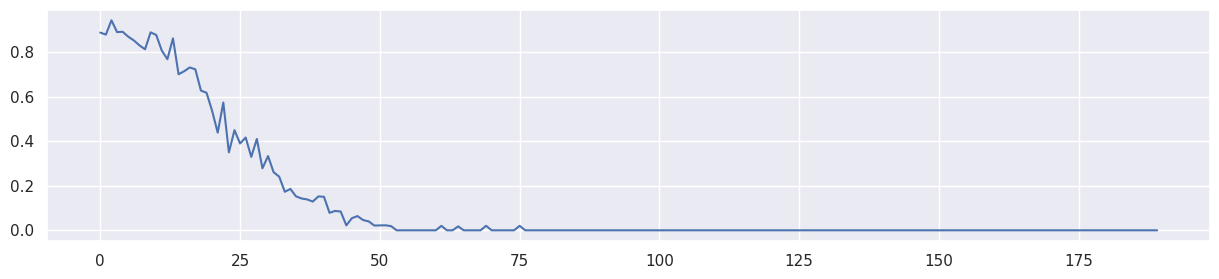

,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Feature 5,0.875000,0.879227,0.718818,0.596685,0.261667
1,Feature 6,0.853933,0.887805,0.121294,0.000000,0.236849


In [19]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0','b']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 6')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## z0를 빼고, 4개 feature로 학습

100%|██████████| 1000/1000 [00:17<00:00, 58.17it/s]


MSE: 0.13
RMSE: 0.36


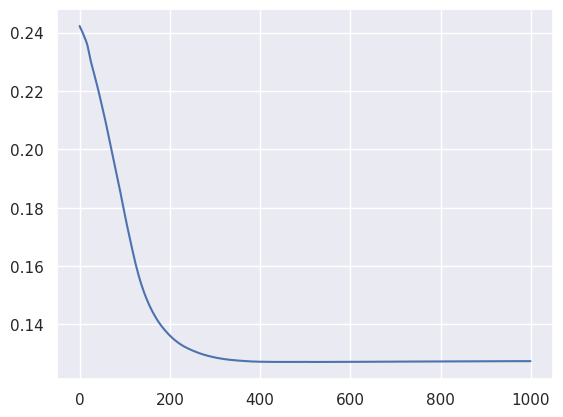

In [20]:
seed_everything()

X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100 # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [21]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.7701149425287357


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 190/190 [00:00<00:00, 603.52it/s]


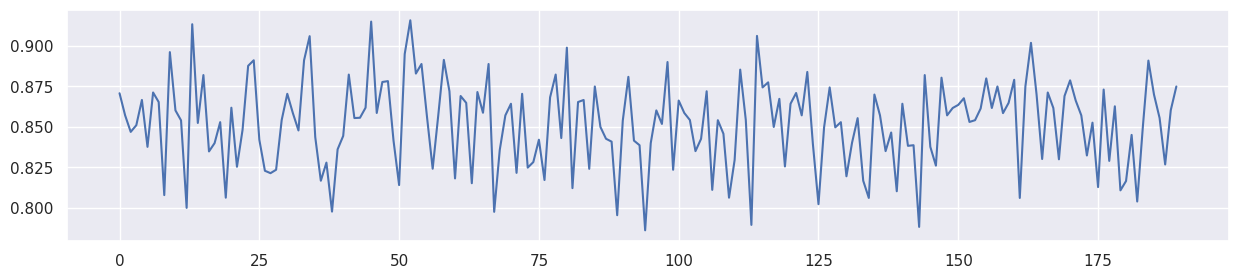

,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Feature 5,0.875000,0.879227,0.718818,0.596685,0.261667
1,Feature 6,0.853933,0.887805,0.121294,0.000000,0.236849
2,Feature 4,0.770115,0.870813,0.851981,0.875000,0.088677


In [22]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(X[1800:2000][['z0']], predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

+ 위에서 보면.... 학습과정에서, 현재는 학습에 효과가 있지만 향후 잠재적으로 성능을 저해할 수 있는 feature를 탐지하여 이의 효과를 경감 또는 (보정) 할 수 있는 학습 방법을 찾아야 하는 것!!!

## RF-Train의 적용

+ 위의 데이터에서, sensitive attribute는 z0에 대당된다.
+ 따라서, MI(y^|z0) = 0 이되어야 하고,
+ Fairness discriminator에서는  Y^과 z0의 loss가 커야 한다! 즉, 최대한 상관 없어야 한다.
+ OK, 일단 이렇게 구성해 본다!

In [23]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 3.66 MiB/s, done.


In [24]:
%cd fr-train
!pwd

/content/fr-train
/content/fr-train


In [25]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

+ Generator의 구현 = 위에서 feature 5개의 model과 동일
+ DiscriminatorF = Y^과 z0가 같아지지 않게 학습 ??

In [26]:

def test_model(model_, tX, ty, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [53]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1),
            nn.Sigmoid()            
        )

    def forward(self, x1, x2):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(torch.cat((x1, x2), 1))
        return predicted_z
    

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF2(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 4),
            nn.Linear(4, 1)       
        )

    def forward(self, x1):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(x1)
        return predicted_z
    

In [28]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    #mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_loss.backward()
        g_losses.append(g_loss)
        optimizer_G.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1, mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1, mi, generator

In [39]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 
        #r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        #f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        d_f_loss =  (r_loss + f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [62]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model22(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF2()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 

        # y와 z는 상관관계가 있으므로... r_loss는 최소화 시키고...
        r_loss = mse_loss(discriminator_F(y_train.reshape(-1,1)), s1_train.reshape(-1,1))
        # y^와 z는 최대한 무관하게... f_loss 최대화 시킨다..
        f_loss = mse_loss(discriminator_F(gen_y), s1_train.reshape(-1,1)) * 0.2

        d_f_loss =  (r_loss - f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [30]:
def test_all_data(generator):

    XT = X[2000:][['x0','x1','x2','x3','z0']]
    yT = y[2000:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 606.90it/s]


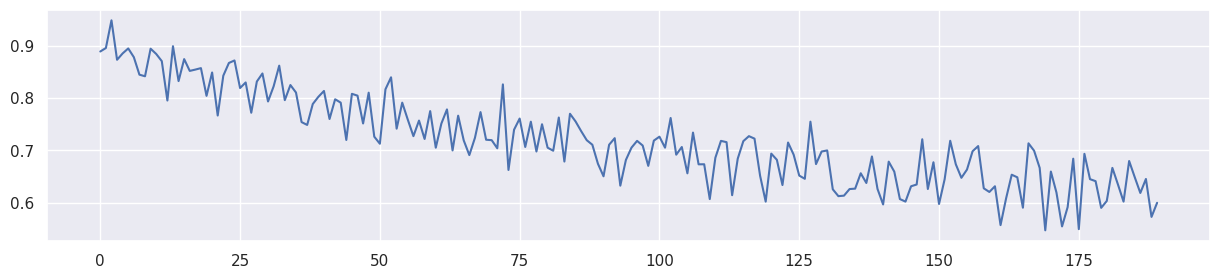

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.764362]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 1.385715] [G loss: 0.748424]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 1.379816] [G loss: 0.721642]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 1.369719] [G loss: 0.692447]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 1.361597] [G loss: 0.661667]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 1.359293] [G loss: 0.629466]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 1.361001] [G loss: 0.596741]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 1.364285] [G loss: 0.563744]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 1.368029] [G loss: 0.531376]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 1.371693] [G loss: 0.499893]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 1.375391] [G loss: 0.471104]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 1.378541] [G loss: 0.446025]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 617.31it/s]


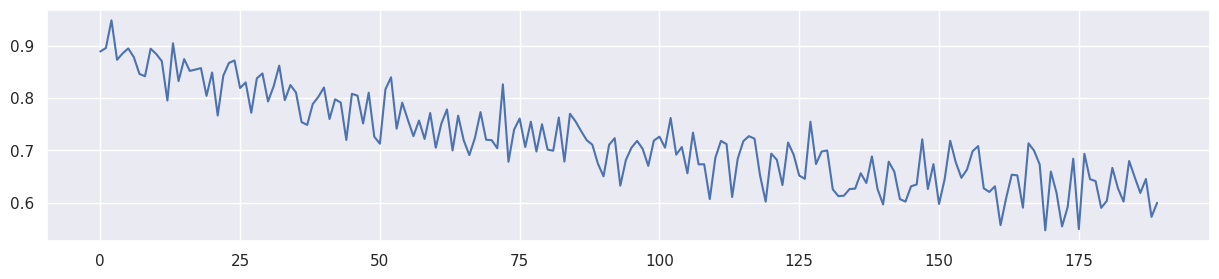

Mean F1 for all data: 0.7199269575388043
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.833470]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 1.385707] [G loss: 0.819187]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 1.379258] [G loss: 0.794397]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 1.366871] [G loss: 0.767057]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 1.356212] [G loss: 0.738834]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 1.352615] [G loss: 0.710249]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 1.354324] [G loss: 0.681624]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 1.358529] [G loss: 0.652855]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 1.363284] [G loss: 0.624683]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 1.367940] [G loss: 0.597247]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 1.372619] [G loss: 0.572237]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 1.376532] [G loss: 0.550378]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 630.17it/s]


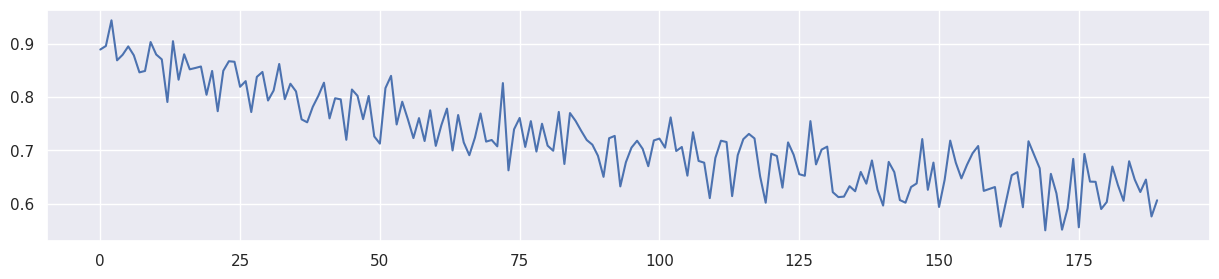

Mean F1 for all data: 0.7205583873659183
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.902577]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 1.385694] [G loss: 0.889952]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 1.378446] [G loss: 0.867016]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 1.362389] [G loss: 0.841007]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 1.346843] [G loss: 0.814998]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 1.340973] [G loss: 0.789855]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 1.342740] [G loss: 0.765414]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 1.347964] [G loss: 0.741051]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 1.354569] [G loss: 0.717223]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 1.361214] [G loss: 0.694206]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 1.367934] [G loss: 0.672915]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 1.373049] [G loss: 0.654381]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 620.34it/s]


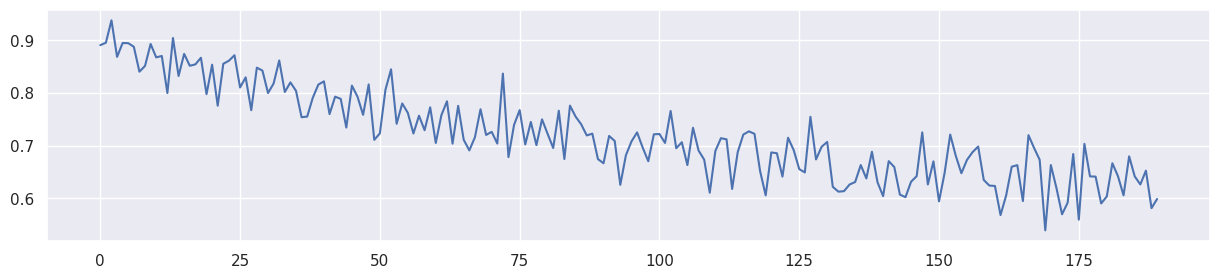

Mean F1 for all data: 0.7214164780211789
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.971684]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 1.385651] [G loss: 0.960716]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 1.377058] [G loss: 0.939390]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 1.354234] [G loss: 0.913654]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 1.329525] [G loss: 0.888927]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 1.318446] [G loss: 0.867105]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 1.319638] [G loss: 0.847040]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 1.326620] [G loss: 0.827323]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 1.335311] [G loss: 0.808170]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 1.345255] [G loss: 0.790189]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 1.355975] [G loss: 0.773466]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 1.364482] [G loss: 0.758701]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 593.23it/s]


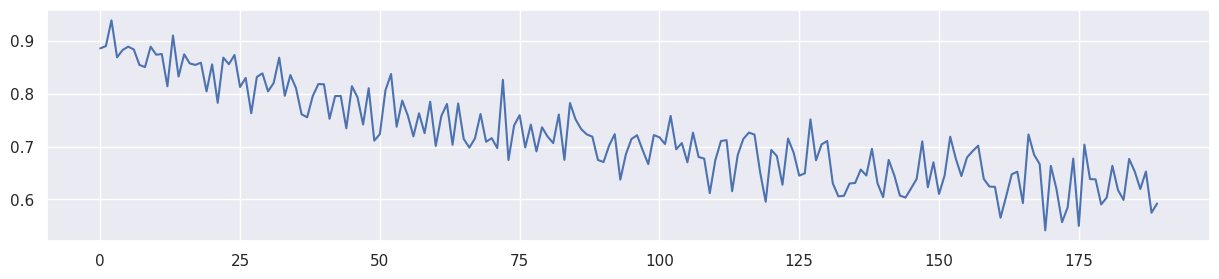

Mean F1 for all data: 0.7198584924509955
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.040792]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 1.385086] [G loss: 1.031416]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 1.365266] [G loss: 1.010256]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 1.314786] [G loss: 0.982919]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 1.272525] [G loss: 0.960884]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 1.258224] [G loss: 0.943746]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 1.258621] [G loss: 0.928428]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 1.265445] [G loss: 0.913316]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 1.274780] [G loss: 0.899293]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 1.288391] [G loss: 0.886958]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 1.305207] [G loss: 0.875826]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 1.322714] [G loss: 0.865882]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 593.98it/s]


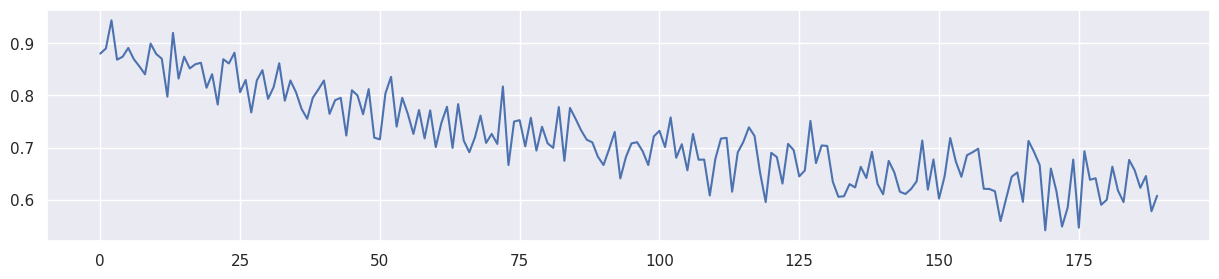

Mean F1 for all data: 0.7197188448434082
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.109899]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 1.384624] [G loss: 1.101906]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 1.359386] [G loss: 1.078351]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 1.286432] [G loss: 1.040596]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 1.209703] [G loss: 1.013609]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 1.178470] [G loss: 1.000641]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 1.171644] [G loss: 0.989958]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 1.170898] [G loss: 0.979577]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 1.171883] [G loss: 0.970392]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 1.174362] [G loss: 0.963220]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 1.180557] [G loss: 0.957649]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 1.187429] [G loss: 0.953300]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 605.44it/s]


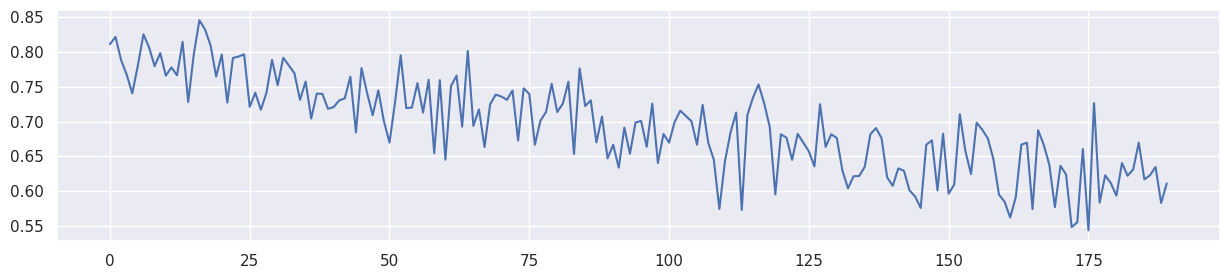

Mean F1 for all data: 0.6939367752835043
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.179006]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 1.384364] [G loss: 1.172318]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 1.352243] [G loss: 1.144222]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 1.258360] [G loss: 1.089529]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 1.159981] [G loss: 1.048331]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 1.106517] [G loss: 1.033059]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 1.087656] [G loss: 1.025751]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 1.081852] [G loss: 1.018620]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 1.079079] [G loss: 1.012759]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 1.078945] [G loss: 1.008387]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 1.079956] [G loss: 1.005195]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 1.082166] [G loss: 1.002947]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 593.91it/s]


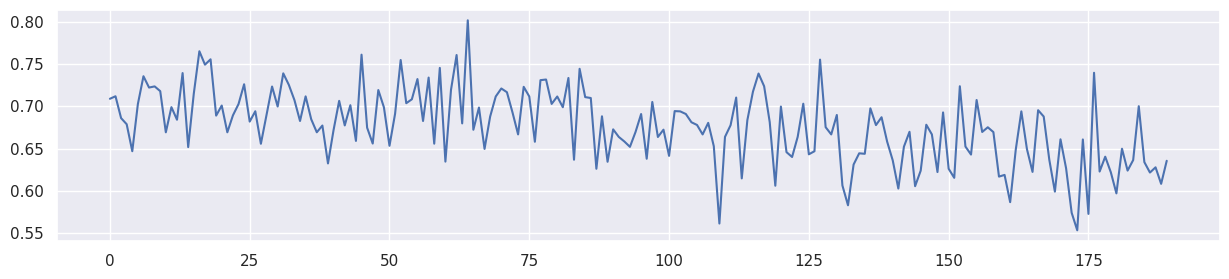

Mean F1 for all data: 0.6760568804559415
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.248114]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 1.383965] [G loss: 1.242565]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 1.342603] [G loss: 1.206555]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 1.228619] [G loss: 1.127630]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 1.110432] [G loss: 1.062805]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 1.041893] [G loss: 1.037911]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 1.013065] [G loss: 1.031554]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 1.004443] [G loss: 1.028972]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 1.003139] [G loss: 1.026490]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 1.004280] [G loss: 1.024115]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 1.005393] [G loss: 1.021932]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 1.006181] [G loss: 1.019991]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 549.76it/s]


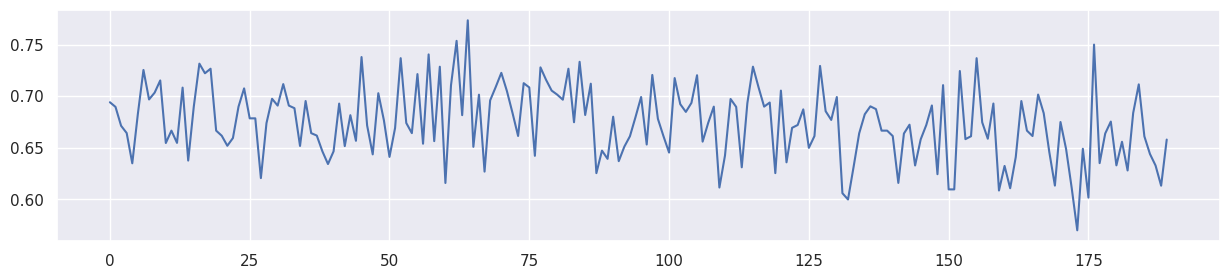

Mean F1 for all data: 0.673983395862796
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.317221]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 1.383212] [G loss: 1.312479]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 1.329523] [G loss: 1.263401]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 1.193672] [G loss: 1.150553]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 1.067594] [G loss: 1.057277]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.996381] [G loss: 1.015475]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.963313] [G loss: 1.003051]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.951129] [G loss: 1.000448]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.947176] [G loss: 0.999522]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.946042] [G loss: 0.998793]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.945847] [G loss: 0.998031]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 0.945854] [G loss: 0.997296]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 599.05it/s]


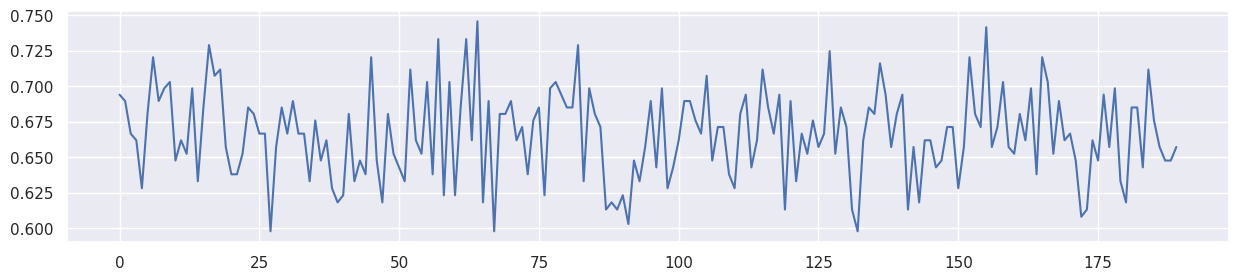

Mean F1 for all data: 0.6660083586974344


,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Feature 5,0.875000,0.879227,0.718818,0.596685,2.616669e-01
1,Feature 6,0.853933,0.887805,0.121294,0.000000,2.368493e-01
2,Feature 4,0.770115,0.870813,0.851981,0.875000,8.867749e-02
0,0.0,0.875000,0.888889,0.719835,0.600000,2.616669e-01
1,0.1,0.875000,0.888889,0.719927,0.600000,2.616669e-01
2,0.2,0.881356,0.888889,0.720558,0.606742,2.598196e-01
3,0.3,0.868571,0.890995,0.721416,0.598870,2.455515e-01
4,0.4,0.865169,0.885714,0.719858,0.592179,2.771431e-01
5,0.5,0.876404,0.880383,0.719719,0.607735,2.707110e-01
6,0.6,0.744589,0.811245,0.693937,0.610837,2.988178e-01


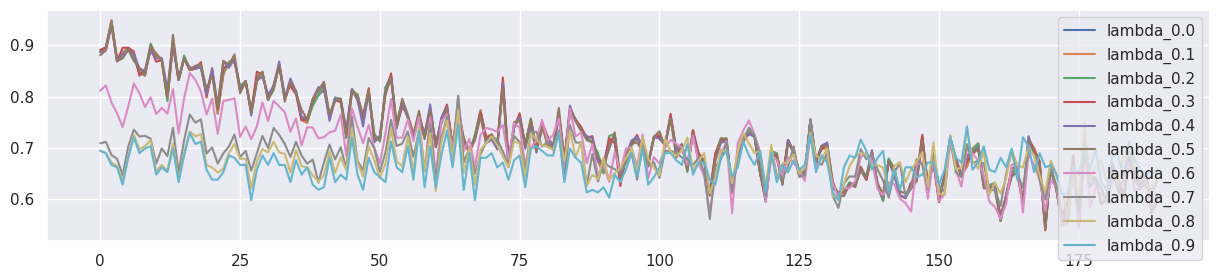

In [44]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 190/190 [00:00<00:00, 602.31it/s]


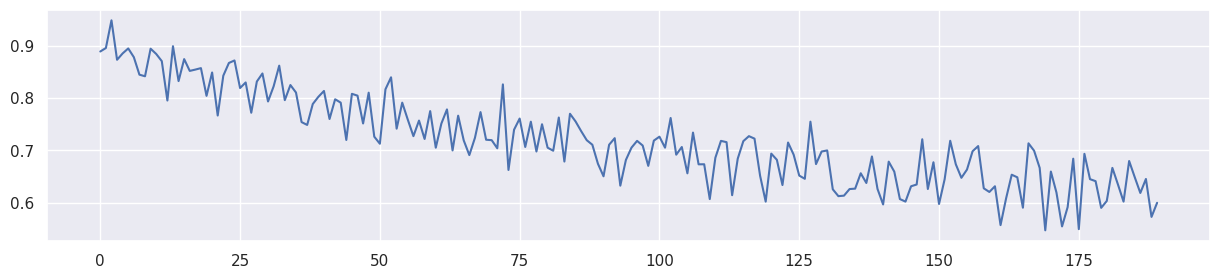

Mean F1 for all data: 0.7198353691465351
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 0.862076]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 0.968830] [G loss: 0.706871]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 0.273386] [G loss: 0.611551]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 0.252632] [G loss: 0.581231]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 0.256065] [G loss: 0.551309]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 0.260366] [G loss: 0.519490]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 0.265285] [G loss: 0.486915]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 0.270510] [G loss: 0.454209]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 0.276017] [G loss: 0.421945]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 0.281302] [G loss: 0.390681]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 0.285962] [G loss: 0.361675]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 0.289781] [G loss: 0.336758]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 596.18it/s]


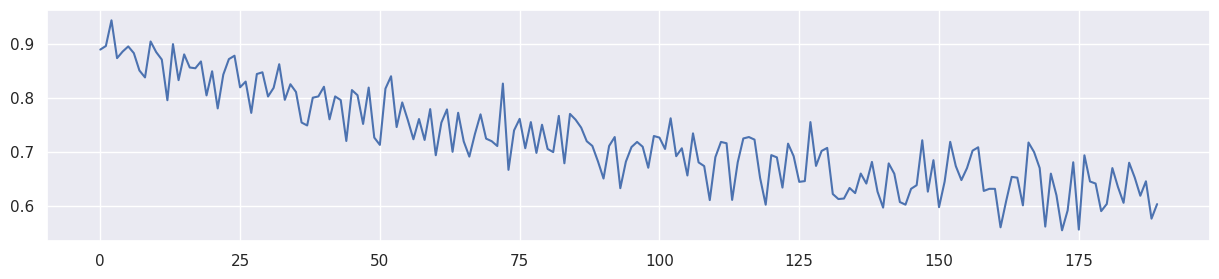

Mean F1 for all data: 0.7213612454075012
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.028898]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 0.968792] [G loss: 0.736075]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 0.273327] [G loss: 0.574269]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 0.252572] [G loss: 0.544917]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 0.255969] [G loss: 0.518645]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 0.260171] [G loss: 0.490850]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 0.264937] [G loss: 0.462475]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 0.269958] [G loss: 0.433995]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 0.275232] [G loss: 0.406071]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 0.280459] [G loss: 0.378775]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 0.285112] [G loss: 0.353456]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 0.289095] [G loss: 0.331553]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 579.05it/s]


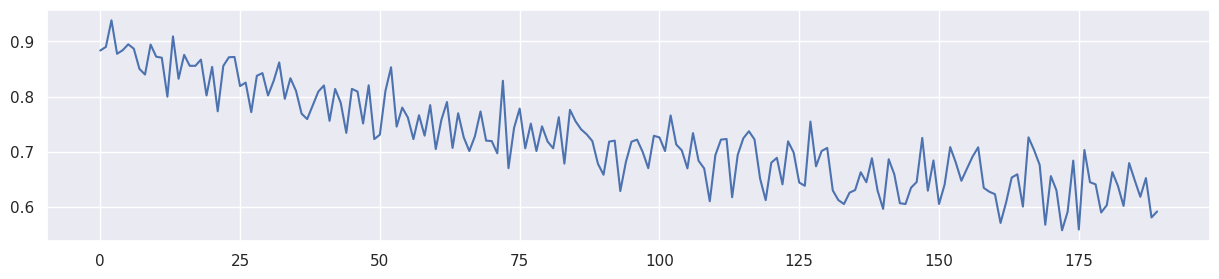

Mean F1 for all data: 0.723196635356523
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.195719]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 0.968739] [G loss: 0.765265]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 0.273249] [G loss: 0.536961]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 0.252503] [G loss: 0.508565]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 0.255848] [G loss: 0.485936]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 0.259898] [G loss: 0.462155]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 0.264434] [G loss: 0.437936]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 0.269307] [G loss: 0.413639]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 0.274241] [G loss: 0.390051]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 0.279310] [G loss: 0.366797]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 0.284012] [G loss: 0.345213]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 0.288001] [G loss: 0.326302]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 566.81it/s]


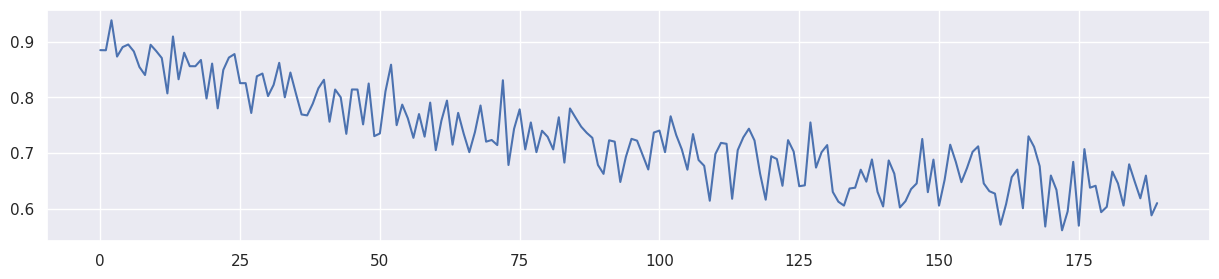

Mean F1 for all data: 0.726365462679275
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.362541]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 0.968660] [G loss: 0.794439]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 0.273139] [G loss: 0.499645]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 0.252415] [G loss: 0.472193]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 0.255666] [G loss: 0.453185]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 0.259522] [G loss: 0.433394]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 0.263784] [G loss: 0.413326]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 0.268332] [G loss: 0.393229]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 0.272863] [G loss: 0.373819]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 0.277819] [G loss: 0.354693]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 0.282457] [G loss: 0.337006]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 0.286635] [G loss: 0.321065]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 588.54it/s]


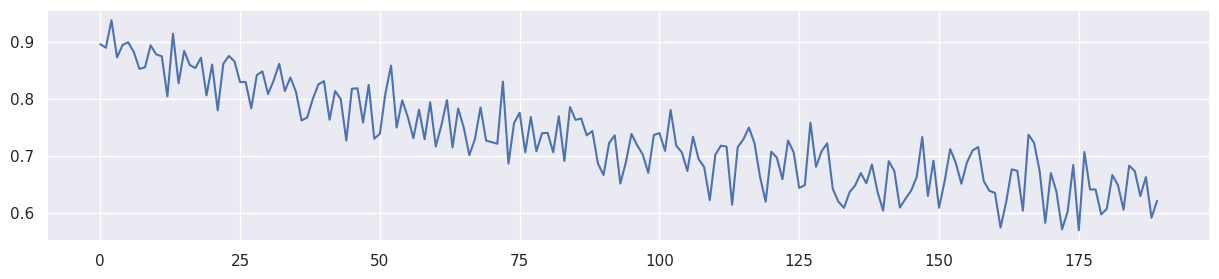

Mean F1 for all data: 0.730987492032082
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.529362]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 0.968542] [G loss: 0.823586]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 0.272976] [G loss: 0.462309]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 0.252289] [G loss: 0.435799]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 0.255411] [G loss: 0.420410]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 0.258978] [G loss: 0.404548]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 0.262769] [G loss: 0.388494]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 0.266930] [G loss: 0.372646]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 0.271060] [G loss: 0.357261]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 0.275456] [G loss: 0.342367]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 0.279962] [G loss: 0.328643]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 0.284234] [G loss: 0.315867]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F l

100%|██████████| 190/190 [00:00<00:00, 543.72it/s]


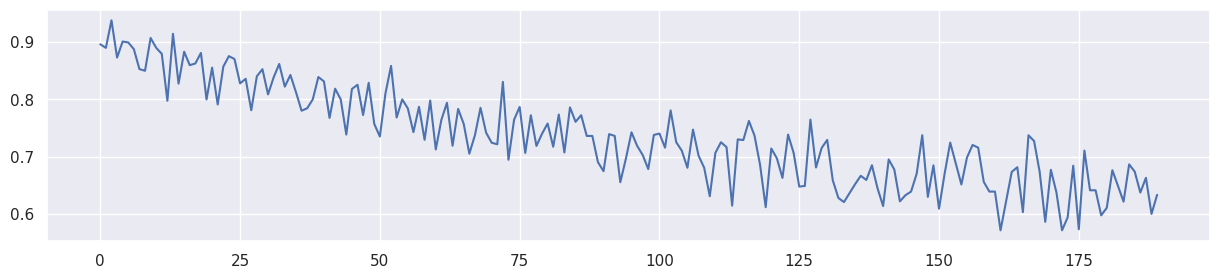

Mean F1 for all data: 0.7351985506205282
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.696184]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 0.968353] [G loss: 0.852679]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 0.272688] [G loss: 0.424955]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 0.252071] [G loss: 0.399419]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 0.254940] [G loss: 0.387646]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 0.258030] [G loss: 0.375603]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 0.261150] [G loss: 0.363514]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 0.264466] [G loss: 0.351776]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 0.268125] [G loss: 0.340468]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 0.271854] [G loss: 0.329673]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 0.275803] [G loss: 0.319933]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 0.279755] [G loss: 0.310934]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 595.33it/s]


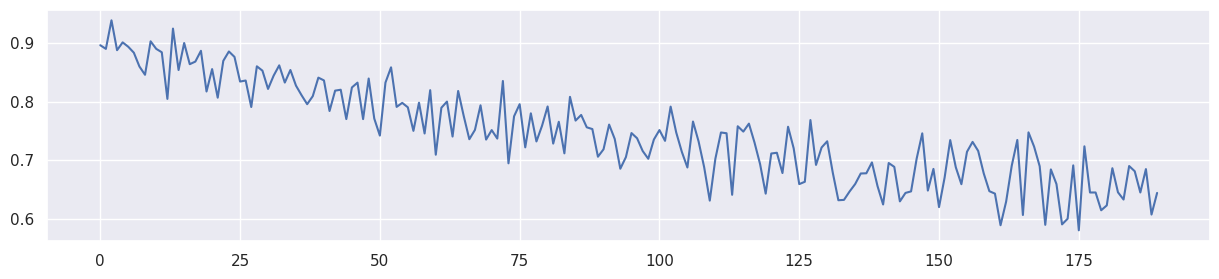

Mean F1 for all data: 0.7460614847368725
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 1.863006]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 0.967984] [G loss: 0.881664]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 0.272091] [G loss: 0.387593]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 0.251562] [G loss: 0.363131]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 0.253895] [G loss: 0.354877]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 0.256094] [G loss: 0.346412]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 0.258103] [G loss: 0.337942]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 0.259972] [G loss: 0.329880]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 0.261820] [G loss: 0.322257]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 0.264060] [G loss: 0.315496]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 0.267047] [G loss: 0.309579]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 0.271011] [G loss: 0.304191]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 597.78it/s]


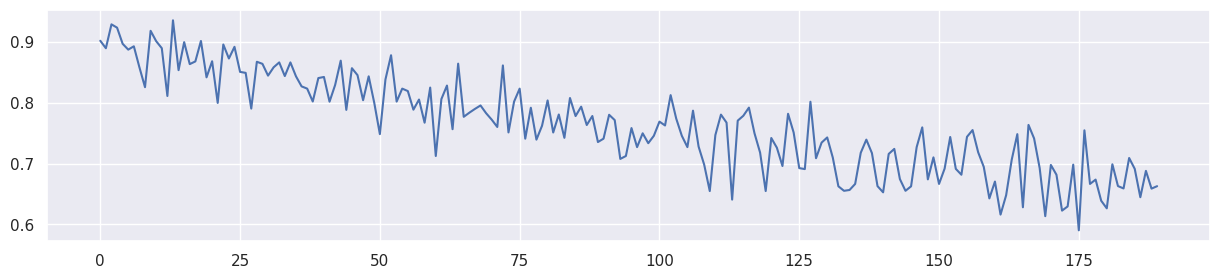

Mean F1 for all data: 0.7643325303860706
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 2.029827]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 0.967109] [G loss: 0.910310]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 0.270296] [G loss: 0.350134]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 0.249830] [G loss: 0.327001]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 0.250636] [G loss: 0.321793]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 0.250575] [G loss: 0.316270]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 0.249552] [G loss: 0.310631]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 0.247460] [G loss: 0.305110]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 0.245454] [G loss: 0.300281]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 0.244539] [G loss: 0.296615]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 0.244849] [G loss: 0.294029]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 0.246501] [G loss: 0.292186]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 574.44it/s]


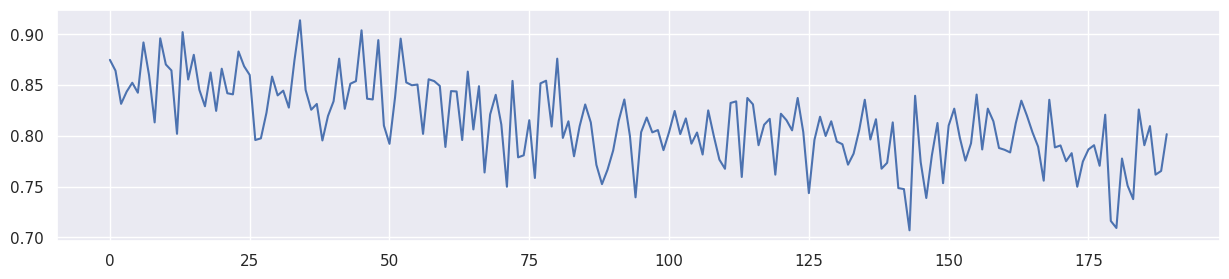

Mean F1 for all data: 0.8135036169680787
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 2.363470] [G loss: 2.196649]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 0.965095] [G loss: 0.937745]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 0.265343] [G loss: 0.309423]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 0.241610] [G loss: 0.287854]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 0.238901] [G loss: 0.284609]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.233094] [G loss: 0.278985]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.221551] [G loss: 0.270723]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.205555] [G loss: 0.261961]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.189516] [G loss: 0.254581]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.176448] [G loss: 0.249856]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.167626] [G loss: 0.247223]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 0.161863] [G loss: 0.245589]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 550.64it/s]


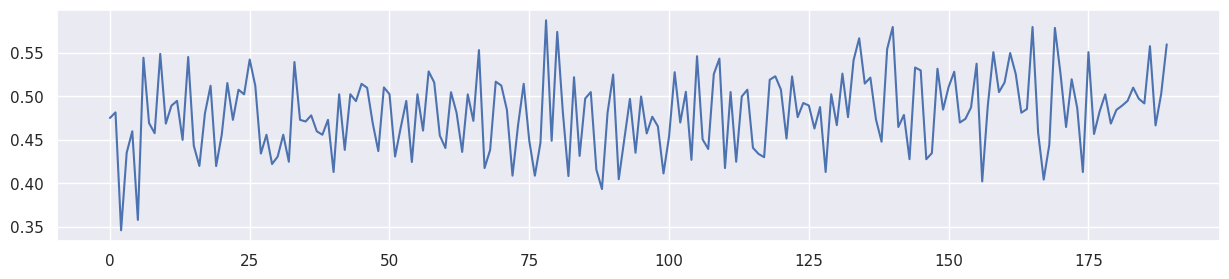

Mean F1 for all data: 0.481489031708359


,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Feature 5,0.875000,0.879227,0.718818,0.596685,0.261667
1,Feature 6,0.853933,0.887805,0.121294,0.000000,0.236849
2,Feature 4,0.770115,0.870813,0.851981,0.875000,0.088677
0,0.0,0.875000,0.888889,0.719835,0.600000,0.261667
1,0.1,0.881356,0.888889,0.721361,0.603352,0.259820
2,0.2,0.868571,0.883495,0.723197,0.592179,0.245552
3,0.3,0.868571,0.884615,0.726365,0.610169,0.245552
4,0.4,0.868571,0.896226,0.730987,0.621469,0.245552
5,0.5,0.875000,0.896226,0.735199,0.633333,0.243805
6,0.6,0.870056,0.896226,0.746061,0.644068,0.228285


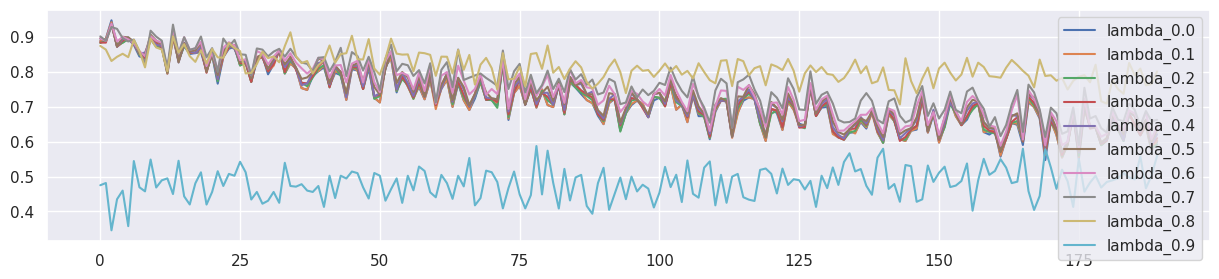

In [63]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model22(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


## MINE를 통해 I(y^,z) 측정

(40000, 5)
(40000,)


100%|██████████| 300/300 [00:00<00:00, 518.37it/s]

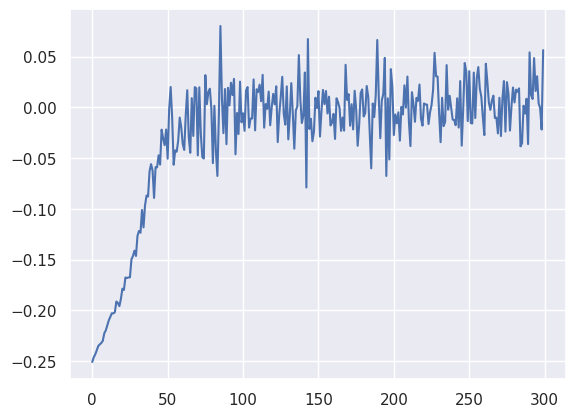

In [32]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 1000

x1 = X[0:1800][['z0']].values
y1 = y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle)))) - 0.25
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss)

In [33]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()

        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        y1 = gen_y[s].data.numpy()
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle)))) - 0.25
        mi_loss = - ret  # maximize
        mine.zero_grad()
        #loss.backward()
        

        mi_losses.append(mi_loss)
        #optimizer_D_F.step()
        
        loss = (1-lambda_f) * g_loss + lambda_f * mi_loss 

        loss.backward()
        optimizer_G.step()
        optimizer.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

In [34]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3] # Lambda value for the fairness discriminator of FR-Train.
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]


KeyboardInterrupt: ignored